In [191]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import torch
torch.manual_seed(2024)

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
import matplotlib
matplotlib.rcParams.update({'font.size': 30, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var, plot_task_rep, plot_3d_embedding
from utils.constants import COLORS

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


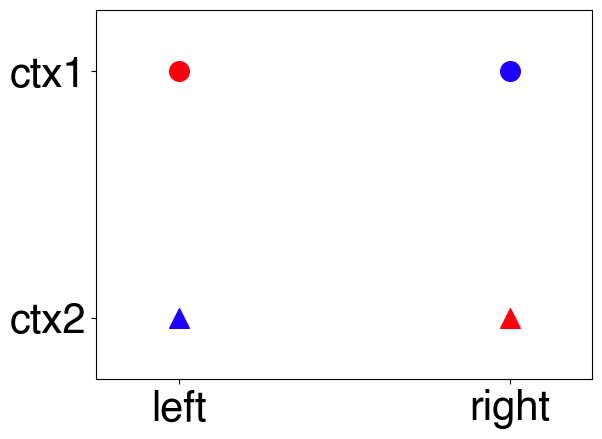

In [154]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

fig = plot_task_rep(X, y)

In [155]:
n_epochs = 5000
dim_input = 2
dim_hidden = 500
dim_output = 1

lr = 2e-3
# Initialization scale
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

init_models = []
trained_models = []

# Training
for w_i, w1_init in enumerate(w1_inits):
    # Model instantiation
    dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    init_models.append(copy.deepcopy(dlnn_model))

    _, _, = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
    trained_models.append(dlnn_model)

In [156]:
rich_models = [init_models[0], trained_models[0]]
lazy_models = [init_models[-1], trained_models[-1]]

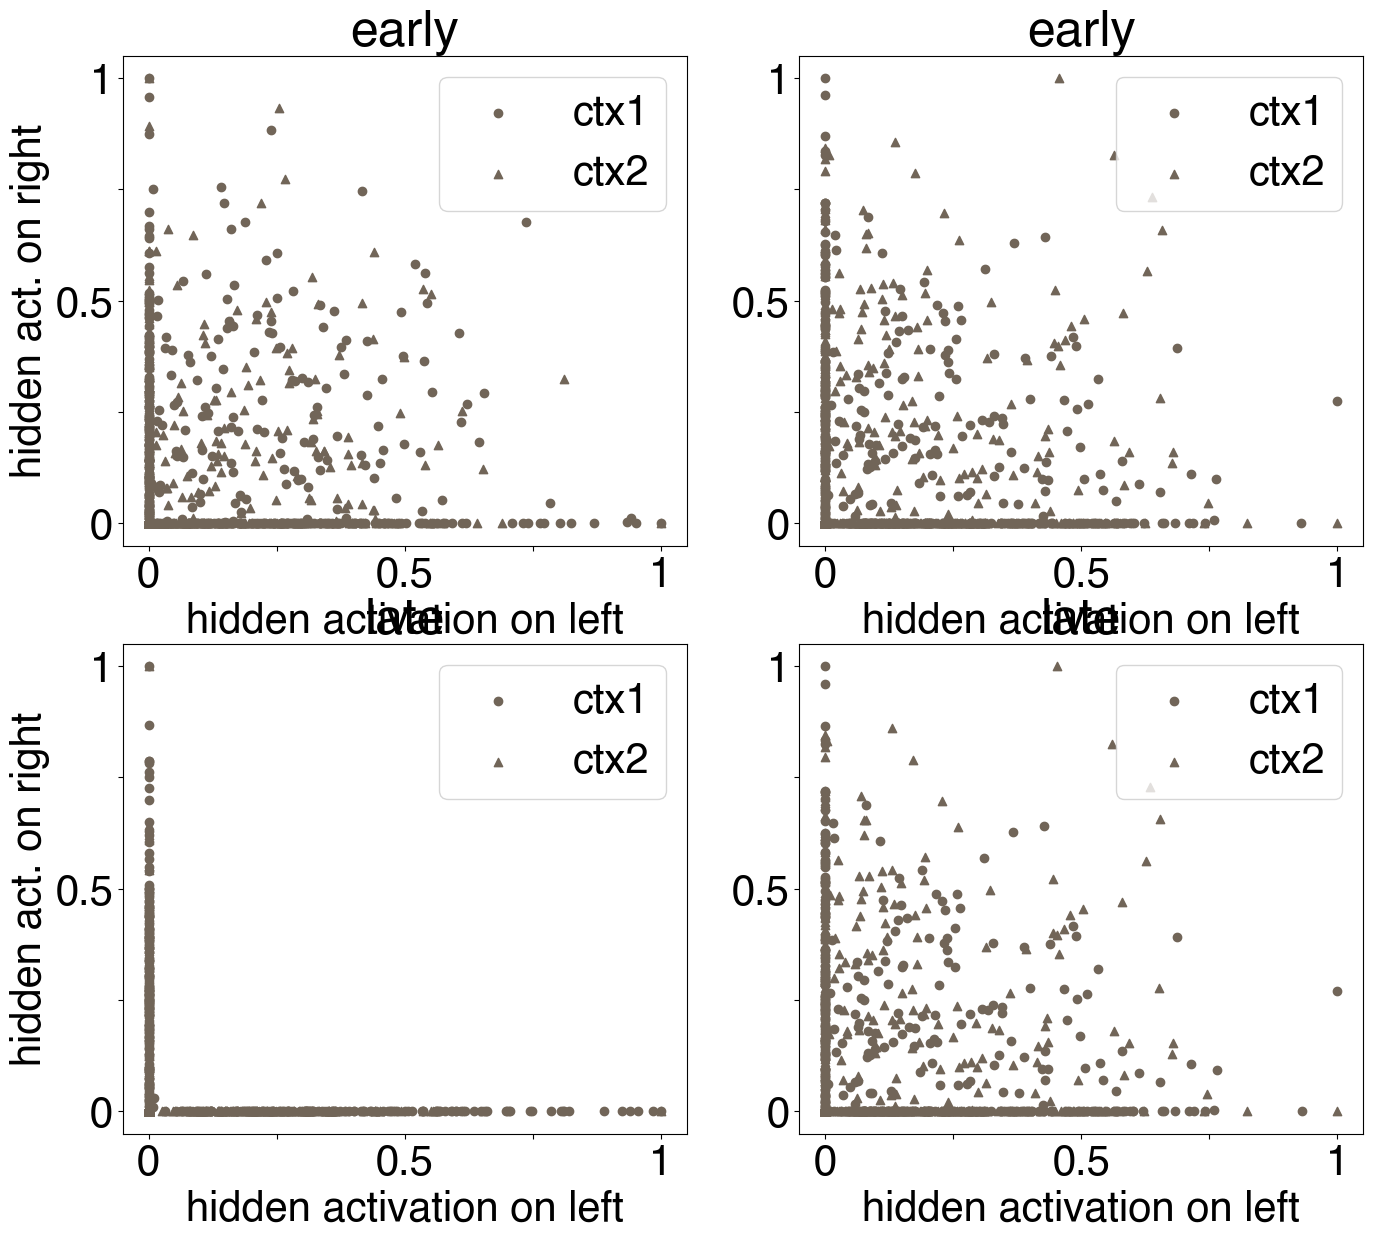

In [180]:
context_labels = ['ctx1', 'ctx2']
context_markers = ['o', '^']
arm_labels = ['left', 'right'] 
context_idx = [[1, 3], [0, 2]]

norm_hidden = np.zeros((4, 4, dim_hidden))

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 14)
for m_i, model in enumerate(rich_models + lazy_models):
    axis = axes.T.flatten()[m_i]
    
    _, hiddens = model(X)
    hidden_act = hiddens.detach().numpy()
    
    # norm_act_all = []
    for c_i, c_label in enumerate(context_labels):
        context_X = X[context_idx[c_i]]
    
        _, hiddens = model(context_X)
        hidden_act = hiddens.detach().numpy()
        # norm_act = [stats.zscore(act) for act in hidden_act]
        norm_act = [(act - act.min()) / (act.max() - act.min()) for act in hidden_act]
        # m, b = np.polyfit(norm_act[0], norm_act[1], 1)
        # norm_act_all.append(norm_act)
        
        # norm_act_diff = np.mean(np.abs(norm_act[0] - norm_act[1]))
        # axis.hist(norm_act[0] - norm_act[1], label=c_label)
        # axis.set_xlabel('FR diff. between L and R')
        # axis.set_ylabel('count')
        # axis.legend()
        
        norm_hidden[m_i, context_idx[c_i], :] = norm_act
        axis.scatter(norm_act[0], norm_act[1], color=(113/255, 101/255, 88/255), marker=context_markers[c_i], label=c_label)
        
    # norm_act_all_concat = np.concatenate(norm_act_all, 1)
    # corr = stats.pearsonr(norm_act_all_concat[0], norm_act_all_concat[1]).statistic
    
    axis.set_xticks([0, 0.25, 0.5, 0.75, 1])
    axis.set_xticklabels([0, None, 0.5, None, 1])
    axis.set_yticks([0, 0.25, 0.5, 0.75, 1])
    axis.set_yticklabels([0, None, 0.5, None, 1])
    
    axis.set_xlabel('hidden activation on left')
    if m_i < 2:
        axis.set_ylabel('hidden act. on right')
    axis.legend()

    if m_i % 2 == 0:
        axis.set_title(f'early')
    else:
        axis.set_title(f'late')
            
fig.savefig("rich_lazy_splitting.svg")

/Users/mac/Projects/replay_task_rep/simulations/utils/plotting.py:116: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axis.scatter(embedding[i, 0], embedding[i, 1], embedding[i, 2], c=colors[i], marker=marker, s=200)


Text(0.5, 0.92, 'dist(L, R) = 36.42')

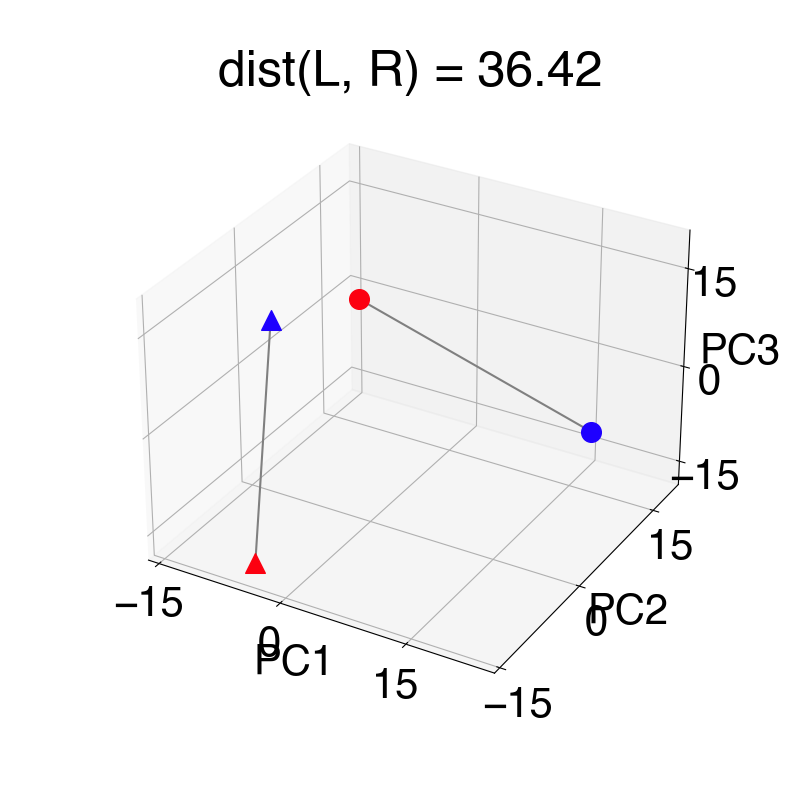

In [183]:
%matplotlib ipympl

rich_norm_hidden = norm_hidden[1]

scaler = StandardScaler()
rich_norm_hidden = scaler.fit_transform(rich_norm_hidden)

pca = PCA(n_components=3)
rich_embed_hidden = pca.fit_transform(rich_norm_hidden)

rich_pairwise_pca = pairwise_distances(rich_embed_hidden, metric='euclidean')
# print(rich_pairwise_pca)
rich_dist_LR = np.mean([rich_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])

fig, axis = plot_3d_embedding(X, y, rich_embed_hidden)
for l_i, r_i in context_idx:
    left_embed = rich_embed_hidden[l_i]
    right_embed = rich_embed_hidden[r_i]
    axis.plot([left_embed[0], right_embed[0]],
              [left_embed[1], right_embed[1]],
              zs=[left_embed[2], right_embed[2]],
              color='grey')

axis.set_title(f'dist(L, R) = {rich_dist_LR:.2f}')

In [131]:
# fig.savefig("rich_embedding.svg")

/Users/mac/Projects/replay_task_rep/simulations/utils/plotting.py:116: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axis.scatter(embedding[i, 0], embedding[i, 1], embedding[i, 2], c=colors[i], marker=marker, s=200)


Text(0.5, 0.92, 'dist(L, R) = 33.90')

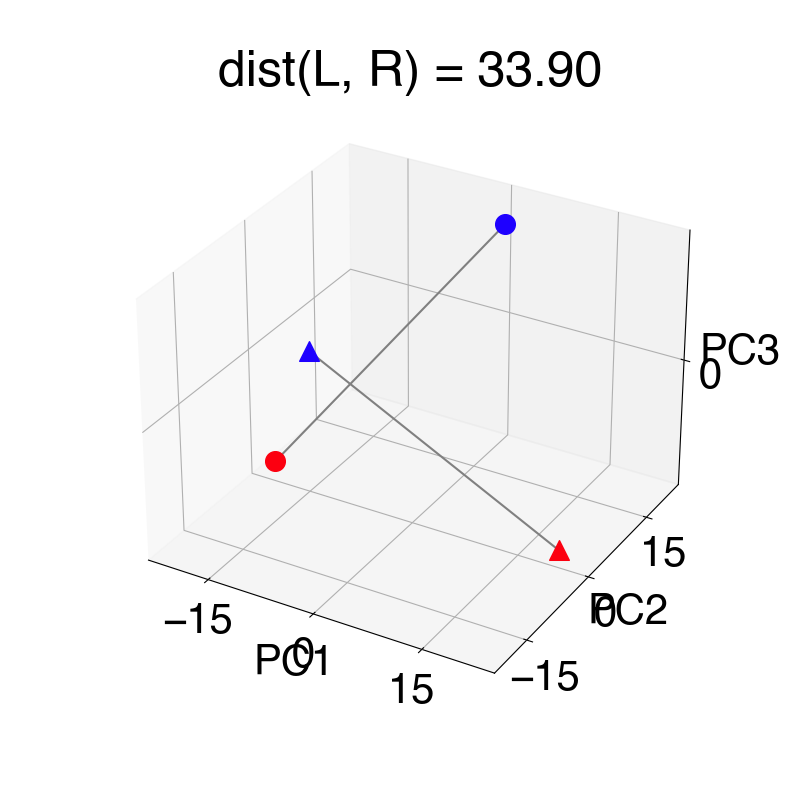

In [184]:
%matplotlib ipympl

lazy_norm_hidden = norm_hidden[3]

scaler = StandardScaler()
lazy_norm_hidden = scaler.fit_transform(lazy_norm_hidden)

pca = PCA(n_components=3)
lazy_embed_hidden = pca.fit_transform(lazy_norm_hidden)

lazy_pairwise_pca = pairwise_distances(lazy_embed_hidden, metric='euclidean')
# print(lazy_pairwise_pca)
lazy_dist_LR = np.mean([lazy_pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])


fig, axis = plot_3d_embedding(X, y, lazy_embed_hidden)
for l_i, r_i in context_idx:
    left_embed = lazy_embed_hidden[l_i]
    right_embed = lazy_embed_hidden[r_i]
    axis.plot([left_embed[0], right_embed[0]],
              [left_embed[1], right_embed[1]],
              zs=[left_embed[2], right_embed[2]],
              color='grey')
    
axis.set_title(f'dist(L, R) = {lazy_dist_LR:.2f}')

In [64]:
# fig.savefig("lazy_embedding.svg")

## Distribution plot of L-R distances in PCA space

In [185]:
num_runs = 1000
model_dist_LR = np.zeros((4, num_runs))
context_idx = [[1, 3], [0, 2]]

# Training
for r_i in range(num_runs):
    for w_i, w1_init in enumerate(w1_inits):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
        init_model = copy.deepcopy(dlnn_model)

        _, _, = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
        trained_model = copy.deepcopy(dlnn_model)

        for m_i, model in enumerate([init_model, trained_model]):
            _, hiddens = model(X)
            hidden_act = hiddens.detach().numpy()

            scaler = StandardScaler()
            norm_hidden = scaler.fit_transform(hidden_act.T).T

            pca = PCA(n_components=3)
            embed_hidden = pca.fit_transform(norm_hidden)
            
            pairwise_pca = pairwise_distances(embed_hidden, metric='euclidean')
            dist_LR = np.mean([pairwise_pca[c_l, c_r] for c_l, c_r in context_idx])
            model_dist_LR[w_i*2+m_i, r_i] = dist_LR

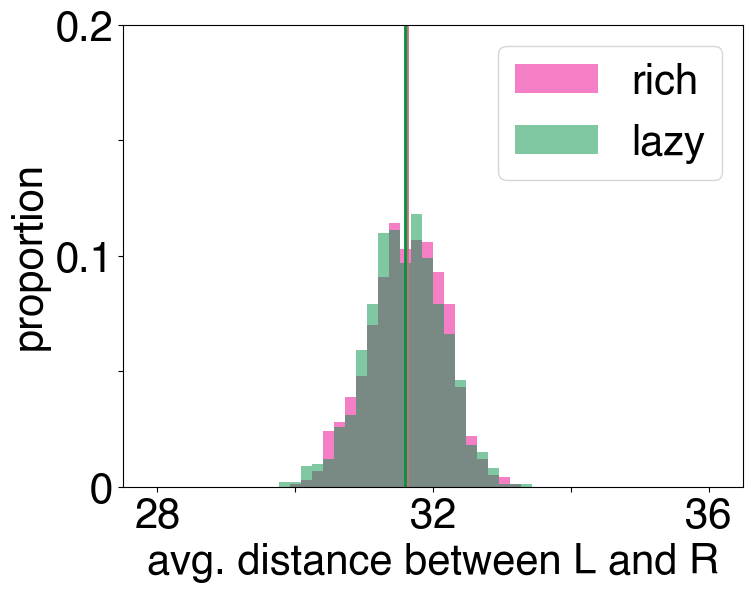

In [193]:
%matplotlib inline
model_titles = ['rich', 'lazy']
mean_colors = [COLORS['hidden_out'], COLORS['hidden_in']]
num_bins = 50
x_lim = [28, 36]

late = False
model_idx = [1, 3] if late else [0, 2]
fig, axis = plt.subplots()
fig.set_size_inches((8, 6))
for i, m_i in enumerate(model_idx):
    title = model_titles[i]
    axis.hist(model_dist_LR[m_i, :], bins=np.arange(*x_lim, (x_lim[1]-x_lim[0]) / num_bins), label=title,
              color=COLORS[title], alpha=0.5, stacked=True)
    axis.axvline(x = np.mean(model_dist_LR[m_i, :]), color = mean_colors[i], linewidth=2)

axis.legend()
axis.set_xlabel('avg. distance between L and R')
axis.set_ylabel('proportion')

axis.set_xlim(27.5, 36.5)
axis.set_xticks([28, 30, 32, 34, 36])
axis.set_xticklabels([28, None, 32, None, 36])

if late:
    axis.set_ylim(0, 400)
    axis.set_yticks([0, 100, 200, 300, 400])
    axis.set_yticklabels([0, None, 0.2, None, 0.4])
else:    
    axis.set_ylim(0, 200)
    axis.set_yticks([0, 50, 100, 150, 200])
    axis.set_yticklabels([0, None, 0.1, None, 0.2])

# fig.savefig("early_rich_lazy_dist.svg")